In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/the-movies-dataset/ratings.csv
/kaggle/input/the-movies-dataset/links_small.csv
/kaggle/input/the-movies-dataset/credits.csv
/kaggle/input/the-movies-dataset/keywords.csv
/kaggle/input/the-movies-dataset/movies_metadata.csv
/kaggle/input/the-movies-dataset/ratings_small.csv
/kaggle/input/the-movies-dataset/links.csv


# MOVIE RECOMMENDATION SYSTEMS

A recommendation model, in simple terms, is an algorithm that aims to provide the most relevant and relatable information to a user depending on the behaviour of the user. Companies like Netflix and Google have a huge database of the behaviours of data collected to be able to perform state-of-the-art recommendations so that they can display the most relevant content or services to the users to increase engagement.

# Collaborative Filtering

Collaborative filtering tackles the similarities between the users and items to perform recommendations. Meaning that the algorithm constantly finds the relationships between the users and in-turns does the recommendations. The algorithm learns the embeddings between the users without having to tune the features. The most common technique is by performing Matrix Factorization to find the embeddings or features that make up the interest of a particular user.

In [2]:
import pandas as pd
import numpy as np

import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt

from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

In [3]:
# Read the movies meta-data(we will be using the feature genre, overview & title from this)
movie_md = pd.read_csv("../input/the-movies-dataset/movies_metadata.csv")

# Read the keywords
movie_keywords = pd.read_csv("../input/the-movies-dataset/keywords.csv")

# Read the credits
movie_credits = pd.read_csv("../input/the-movies-dataset/credits.csv")

In [4]:
movie_md.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


We are gonna select movies which have more than 55 vote count

In [5]:
movie_md = movie_md[movie_md['vote_count']>=55]

In [6]:
movie_md = movie_md[['id','original_title','overview','genres']]

In [7]:
# Creating a duplicate column for title so that once can be used to search later and one for creating features
movie_md['title'] = movie_md['original_title'].copy()

In [8]:
movie_md.reset_index(inplace=True, drop=True)
movie_md.head()

,id,original_title,overview,genres,title
0,862,Toy Story,"Led by Woody, Andy's toys live happily in his ...","[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",Toy Story
1,8844,Jumanji,When siblings Judy and Peter discover an encha...,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",Jumanji
2,15602,Grumpier Old Men,A family wedding reignites the ancient feud be...,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",Grumpier Old Men
3,11862,Father of the Bride Part II,Just when George Banks has recovered from his ...,"[{'id': 35, 'name': 'Comedy'}]",Father of the Bride Part II
4,949,Heat,"Obsessive master thief, Neil McCauley leads a ...","[{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...",Heat


From movies metadata column we are going to work with the following features -

* Genres

* Original Title

* Overview

* id

In [9]:
movie_keywords.head()

,id,keywords
0,862,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,8844,"[{'id': 10090, 'name': 'board game'}, {'id': 1..."
2,15602,"[{'id': 1495, 'name': 'fishing'}, {'id': 12392..."
3,31357,"[{'id': 818, 'name': 'based on novel'}, {'id':..."
4,11862,"[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n..."


From movies keywords column we are going to work with the following features -

* keywords (to fetch the keywords)

* id (to merge dataframe)

In [10]:
movie_credits.head()

,cast,crew,id
0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",862
1,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",8844
2,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...",15602
3,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...",31357
4,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...",11862


From movies credits column we are going to work with the following features -

* cast - To get the name of the actors
* id - To merge dataframe

In [11]:
movie_credits = movie_credits[['id','cast']]

**Data Cleaning & Preprocessing**

In [12]:
# Removing the records for which the id is not available
movie_md = movie_md[movie_md['id'].str.isnumeric()]

**Merge dataframes into one single entity******

In [13]:
# Merge all dataframe as a single entity
# To merge the ids must be of same datatype
movie_md['id'] = movie_md['id'].astype(int)

# Merge
df = pd.merge(movie_md, movie_keywords, on='id', how='left')

# Reset the index
df.reset_index(inplace=True, drop=True)

In [14]:
# Merge with movie credits
df = pd.merge(df, movie_credits, on='id', how='left')

# Reset the index
df.reset_index(inplace=True, drop=True)

In [15]:
df.head()

,id,original_title,overview,genres,title,keywords,cast
0,862,Toy Story,"Led by Woody, Andy's toys live happily in his ...","[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",Toy Story,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,...","[{'cast_id': 14, 'character': 'Woody (voice)',..."
1,8844,Jumanji,When siblings Judy and Peter discover an encha...,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",Jumanji,"[{'id': 10090, 'name': 'board game'}, {'id': 1...","[{'cast_id': 1, 'character': 'Alan Parrish', '..."
2,15602,Grumpier Old Men,A family wedding reignites the ancient feud be...,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",Grumpier Old Men,"[{'id': 1495, 'name': 'fishing'}, {'id': 12392...","[{'cast_id': 2, 'character': 'Max Goldman', 'c..."
3,11862,Father of the Bride Part II,Just when George Banks has recovered from his ...,"[{'id': 35, 'name': 'Comedy'}]",Father of the Bride Part II,"[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n...","[{'cast_id': 1, 'character': 'George Banks', '..."
4,949,Heat,"Obsessive master thief, Neil McCauley leads a ...","[{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...",Heat,"[{'id': 642, 'name': 'robbery'}, {'id': 703, '...","[{'cast_id': 25, 'character': 'Lt. Vincent Han..."


**Let's fetch the genres, keywords, cast to vectorize them later**

In [16]:
# Lets first start with cleaning the movies metadata
# Fetchin the genre list from the column
df['genres'] = df['genres'].apply(lambda x: [i['name'] for i in eval(x)])

# Replaces spaces in between genre(ex - sci fi to scifi) and make it a string
df['genres'] = df['genres'].apply(lambda x: ' '.join([i.replace(" ","") for i in x]))

In [17]:
# Filling the numm values as []
df['keywords'].fillna('[]', inplace=True)

In [18]:
# Let's clean the keywords dataframe to extract the keywords
# Fetchin the keyword list from the column     
df['keywords'] = df['keywords'].apply(lambda x: [i['name'] for i in eval(x)])

# Remove the expty spaces and join all the keyword wwwith spaces
df['keywords'] = df['keywords'].apply(lambda x: ' '.join([i.replace(" ",'') for i in x]))

In [19]:
# Filling the numm values as []
df['cast'].fillna('[]', inplace=True)

In [20]:
# Let's clean the cast dataframe to extract the name of aactors from cast column
# Fetchin the cast list from the column
df['cast'] = df['cast'].apply(lambda x: [i['name'] for i in eval(x)])

# Remove the expty spaces and join all the cast with spaces
df['cast'] = df['cast'].apply(lambda x: ' '.join([i.replace(" ",'') for i in x]))

In [21]:
df.head()

,id,original_title,overview,genres,title,keywords,cast
0,862,Toy Story,"Led by Woody, Andy's toys live happily in his ...",Animation Comedy Family,Toy Story,jealousy toy boy friendship friends rivalry bo...,TomHanks TimAllen DonRickles JimVarney Wallace...
1,8844,Jumanji,When siblings Judy and Peter discover an encha...,Adventure Fantasy Family,Jumanji,boardgame disappearance basedonchildren'sbook ...,RobinWilliams JonathanHyde KirstenDunst Bradle...
2,15602,Grumpier Old Men,A family wedding reignites the ancient feud be...,Romance Comedy,Grumpier Old Men,fishing bestfriend duringcreditsstinger oldmen,WalterMatthau JackLemmon Ann-Margret SophiaLor...
3,11862,Father of the Bride Part II,Just when George Banks has recovered from his ...,Comedy,Father of the Bride Part II,baby midlifecrisis confidence aging daughter m...,SteveMartin DianeKeaton MartinShort KimberlyWi...
4,949,Heat,"Obsessive master thief, Neil McCauley leads a ...",Action Crime Drama Thriller,Heat,robbery detective bank obsession chase shootin...,AlPacino RobertDeNiro ValKilmer JonVoight TomS...


**Let's merge all content/description of movies as a single feature**

In [22]:
df['tags'] = df['overview'] + ' ' + df['genres'] +  ' ' + df['original_title'] + ' ' + df['keywords'] + ' ' + df['cast']

In [23]:
# Delete useless columns
df.drop(columns=['genres','overview','original_title','keywords','cast'], inplace=True)

In [24]:
df.head()

,id,title,tags
0,862,Toy Story,"Led by Woody, Andy's toys live happily in his ..."
1,8844,Jumanji,When siblings Judy and Peter discover an encha...
2,15602,Grumpier Old Men,A family wedding reignites the ancient feud be...
3,11862,Father of the Bride Part II,Just when George Banks has recovered from his ...
4,949,Heat,"Obsessive master thief, Neil McCauley leads a ..."


In [25]:
df.isnull().sum()

id        0
title     0
tags     35
dtype: int64

* These null values are the values for which the data was not available, hence, we would have to remove these records inorder to proceed further

In [26]:
df.drop(df[df['tags'].isnull()].index, inplace=True)

In [27]:
df.head()

,id,title,tags
0,862,Toy Story,"Led by Woody, Andy's toys live happily in his ..."
1,8844,Jumanji,When siblings Judy and Peter discover an encha...
2,15602,Grumpier Old Men,A family wedding reignites the ancient feud be...
3,11862,Father of the Bride Part II,Just when George Banks has recovered from his ...
4,949,Heat,"Obsessive master thief, Neil McCauley leads a ..."


In [28]:
df.shape

(8735, 3)

In [29]:
df.drop_duplicates(inplace=True)

In [30]:
df.shape

(8595, 3)

# Collaborative Filtering System:- 


The engine that was built earlier was not really personal in that it doesn’t capture the personal 
tastes and biases of a user. Anyone querying the system will receive the same 
recommendations for that movie, regardless of who she/he is. Collaborative filtering systems 
differed from the previous approach that didn’t involve other users. This approach is based 
on the idea that the test user will be recommended movies that are watched and liked by 
similar users. This type of collaborative filtering approach is called the User-to-User 
Collaborative filtering approach as we find similar users to our user. It is currently one of the 
most frequently used approaches and usually provides better results than content-based 
recommendations. Some examples of this are found in the recommendation systems of 
YouTube, Netflix, and Spotify. To determine whether the two users are similar or not, we 
consider the movies watched by both of them and how they rated them. Thus, by looking at 
items in common, we will predict the ratings a user will give to a movie who hasn’t watched 
it yet, based on its similar user rates. 
The algorithms are divided into two categories based on their workings memory based and 
model based. 

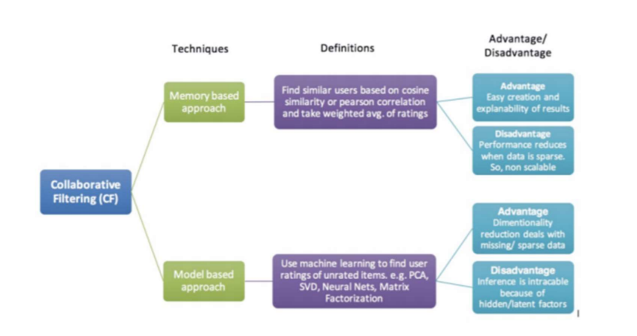

# Model Based Recommender Systems

These methods are based on machine learning and data mining techniques. The goal is to 
train models to be able to make predictions. Model-based algorithms first construct a model 
to represent the behavior of the users and, therefore, to predict their ratings. The parameters 
of the model are estimated using the data from the rating matrix. For instance, we could use 
existing user-item interactions to train a model to predict the top-10 items that a user might 
like the most. One advantage of these methods is that they are able to recommend a larger 
number of items to a larger number of users, compared to other methods like memory-based. 
We say they have large coverage, even when working with large sparse matrices. In the 
literature there are different approaches, associated with machine learning: linear algebra 
methods (SVD etc)

Model-based recommendation systems involve building a model based on the dataset of ratings. In other words, we extract some information from the dataset, and use that as a "model" to make recommendations without having to use the complete dataset every time.

For model based recommender systems we are going to use a library called Surprise and we are going to use SVD as a matrix factorization method.



**Singular Value Decomposition (SVD)**

Singular Value Decomposition (SVD) is one of the matrix factorization method in machine learning. Singular value decomposition decomposes a matrix into three other matrices and extracts the features from the factorization of a high-level (user-item-rating) matrix

The formula of SVD can be given as -



Where,

Matrix U: Latent features of Users

Matrix S: Diagonal matrix representing the strength of each feature

Matrix U: Latent features of Items

**Import Libraries**

In [31]:
from surprise import Dataset, Reader

from surprise.prediction_algorithms.matrix_factorization import SVD

from surprise import accuracy

**Read the data**

In [32]:
ratings = pd.read_csv("../input/the-movies-dataset/ratings_small.csv")

movie_md = pd.read_csv("../input/the-movies-dataset/movies_metadata.csv")

ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


* We will consider ratings for movies which have more than 65 counts

In [33]:
# movie dataframe with votes more than 55
movie_md = movie_md[movie_md['vote_count']>55][['id','title']]

# IDs of movies with count more than 55
movie_ids = [int(x) for x in movie_md['id'].values]

# Select ratings of movies with more than 55 counts
ratings = ratings[ratings['movieId'].isin(movie_ids)]

# Reset Index
ratings.reset_index(inplace=True, drop=True)

# Print first 5 rows
ratings.head()

,userId,movieId,rating,timestamp
0,1,1371,2.5,1260759135
1,1,2105,4.0,1260759139
2,1,2294,2.0,1260759108
3,2,17,5.0,835355681
4,2,62,3.0,835355749


In [34]:
ratings.shape

(29965, 4)

In [35]:
# Initialize a surprise reader object
reader = Reader(line_format='user item rating', sep=',', rating_scale=(0,5), skip_lines=1)

# Load the data
data = Dataset.load_from_df(ratings[['userId','movieId','rating']], reader=reader)

# Build trainset object(perform this only when you are using whole dataset to train)
trainset = data.build_full_trainset()

In [36]:
# Initialize model
svd = SVD()

# cross-validate
svd.fit(trainset)

**We have fit the data successfully, now let's check some predictions**

In [37]:
svd.predict(uid=3,iid=2959,r_ui=5.0)

Prediction(uid=3, iid=2959, r_ui=5.0, est=4.125706534773, details={'was_impossible': False})

In [38]:
svd.predict(uid=15,iid=2678,r_ui=1.0)

Prediction(uid=15, iid=2678, r_ui=1.0, est=2.8274738815107847, details={'was_impossible': False})

When are using .predict() method where we are passing 3 arguments,i.e. userID(uid), itemID(iid) and r_ui(true rating)

The output of each prediction is a tuple where est is our estimated ratings.

We can see that our model is able to perform good and is able to make good predictions. However, this model can be further improved by using hyperparameter optimization techinique.

Now that our models is ready we will be filling the user-item interaction matrix and will be making recommendations.

In [39]:
def get_recommendations(data, movie_md, user_id, top_n, algo):
    
    # creating an empty list to store the recommended product ids
    recommendations = []
    
    # creating an user item interactions matrix 
    user_movie_interactions_matrix = data.pivot(index='userId', columns='movieId', values='rating')
    
    # extracting those product ids which the user_id has not interacted yet
    non_interacted_movies = user_movie_interactions_matrix.loc[user_id][user_movie_interactions_matrix.loc[user_id].isnull()].index.tolist()
    
    # looping through each of the product ids which user_id has not interacted yet
    for item_id in non_interacted_movies:
        
        # predicting the ratings for those non interacted product ids by this user
        est = algo.predict(user_id, item_id).est
        
          # appending the predicted ratings
        movie_name = movie_md[movie_md['id']==str(item_id)]['title'].values[0]
        recommendations.append((movie_name, est))

    # sorting the predicted ratings in descending order
    recommendations.sort(key=lambda x: x[1], reverse=True)

    return recommendations[:top_n] # returing top n highest predicted rating products for this user

In [40]:
get_recommendations(data=ratings,movie_md=movie_md, user_id=654, top_n=10, algo=svd)

[('Nell', 4.945774675665953),
 ('Galaxy Quest', 4.941258263783866),
 ('The Thomas Crown Affair', 4.926408119762461),
 ('Straw Dogs', 4.921663081770739),
 ('Hard Target', 4.9198394372595144),
 ('While You Were Sleeping', 4.894754858978054),
 ('Frankenstein', 4.88710607472467),
 ('The Thomas Crown Affair', 4.8759295620312475),
 ('The Sixth Sense', 4.860845300953682),
 ('Dead Man', 4.8534187242457865)]

# MEMORY BASED RECOMMENDER SYSTEMS

In Memory based, there are two approaches: the primary one identifies clusters of users and 
utilizes the interactions of one specific user to predict the interactions of other similar users. 
The second approach identifies clusters of items that have been rated by user A and utilizes 
them to predict the interaction of user A with a different but similar item B. These methods 
usually encounter major problems with large sparse matrices, since the amount of user-item 
interactions are often too low for generating top quality clusters.

Memory-based methods use user rating historical data to compute the similarity between users or items. The idea behind these methods is to define a similarity measure between users or items, and find the most similar to recommend unseen items. Memory based recommender systems are of 2 types -

User-Based

Item-Bassed


User-Based
In user based recommendation method we will be computing similarities between users and will fetch the most similar users using an algorithm(KNN) and will recommend movies which one user likes to another user and vice versa

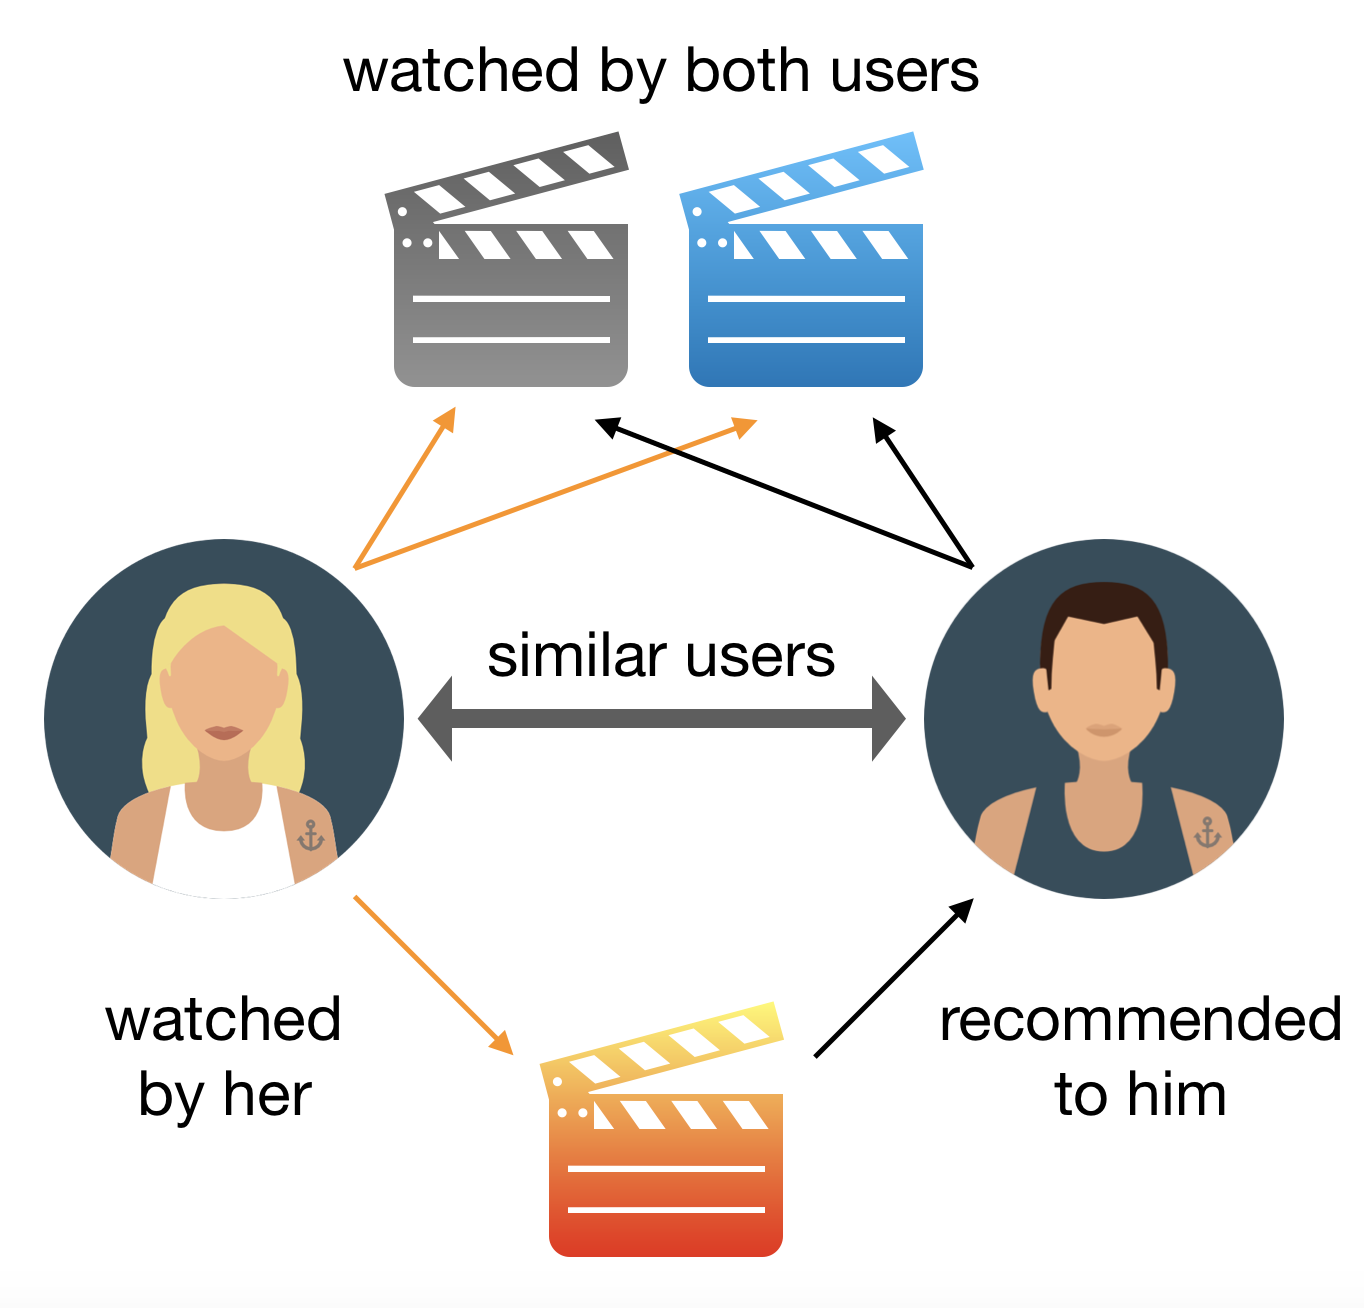

**Import Libraries**

In [41]:
from surprise.prediction_algorithms.knns import KNNBasic

In [42]:
#Declaring the similarity options.
sim_options = {'name': 'cosine',
               'user_based': True}

# KNN algorithm is used to find similar items
sim_user = KNNBasic(sim_options=sim_options, verbose=False, random_state=33)

# Train the algorithm on the trainset, and predict ratings for the testset
sim_user.fit(trainset)

In [43]:
#predicting rating for a sample user with an interacted product.
sim_user.predict(uid=2,iid=17,r_ui=5.0)

Prediction(uid=2, iid=17, r_ui=5.0, est=4.166335018545322, details={'actual_k': 40, 'was_impossible': False})

In [44]:
#predicting rating for a sample user with an interacted product.
sim_user.predict(uid=671,iid=4011,r_ui=4.0)

Prediction(uid=671, iid=4011, r_ui=4.0, est=4.262454431125302, details={'actual_k': 40, 'was_impossible': False})

In [45]:
get_recommendations(ratings, movie_md, 671,10,sim_user)

[('The Wizard', 5),
 ('Rio Bravo', 5),
 ('The Celebration', 5),
 ('Spider-Man 3', 5),
 ('A Streetcar Named Desire', 5),
 ('Gentlemen Prefer Blondes', 5),
 ('The Evil Dead', 5),
 ('JFK', 5),
 ('Strangers on a Train', 5),
 ("Singin' in the Rain", 5)]

**Item-Based**
In item based recommendation method we will be computing similarities between items(movies) and will fetch the most similar items(movies) using an algorithm(KNN) and will recommend items(movies) which one user likes to another user who likes similar kind of item(movie) and vice versa.
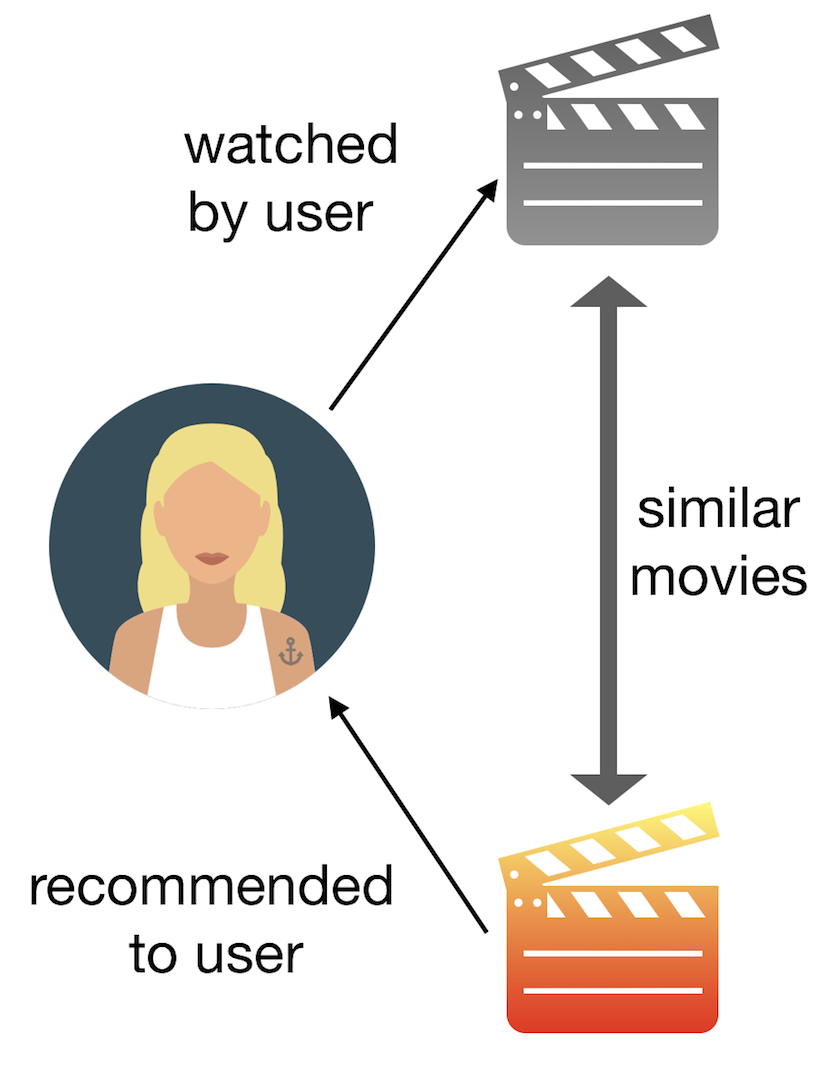


In modelling part there is gonna be just one simple difference, we would have to set the user_based as False in sim_options parameter while initializing model.

In [46]:
#Declaring the similarity options.
sim_options = {'name': 'cosine',
               'user_based': False}

# KNN algorithm is used to find similar items
sim_item = KNNBasic(sim_options=sim_options, verbose=False, random_state=33)

# Train the algorithm on the trainset, and predict ratings for the testset
sim_item.fit(trainset)

In [47]:
#predicting rating for a sample user with an interacted product.
sim_item.predict(uid=2,iid=17,r_ui=5.0)

Prediction(uid=2, iid=17, r_ui=5.0, est=3.650476877827318, details={'actual_k': 40, 'was_impossible': False})

In [48]:
#predicting rating for a sample user with an interacted product.
sim_item.predict(uid=671,iid=4011,r_ui=4.0)

Prediction(uid=671, iid=4011, r_ui=4.0, est=4.164142698155605, details={'actual_k': 31, 'was_impossible': False})

In [49]:
get_recommendations(ratings, movie_md, 671,10,sim_item)

[('Hard Candy', 5),
 ('Visitor Q', 5),
 ('The Protector', 4.666666666666667),
 ('Shaun of the Dead', 4.571428571428571),
 ('The Silence of the Lambs', 4.503228000162119),
 ("Singin' in the Rain", 4.5),
 ("Hearts of Darkness: A Filmmaker's Apocalypse", 4.5),
 ('Sense and Sensibility', 4.5),
 ("The Hitchhiker's Guide to the Galaxy", 4.5),
 ('Fantasia', 4.428571428571429)]